## UNET Training for SEM Grain images

This notebook uses pytorch to create a 3 class (background, grains, inclusions) semantic deep convolutional neural network. 

You can get the data and labels for this example [here](https://www.dropbox.com/scl/fo/6t4fem9zrr6o5eeimjiot/AKV1seHOg_8FTfteLCGYRQM?rlkey=her1eoxy9cstmy7k0giwl2cxa&st=6gzd4cak&dl=0)

Data was provided by [Sreenivas Bhattiprolu](https://www.linkedin.com/in/digitalsreeni/)

In [1]:
import napari
viewer = napari.Viewer()

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import datetime
from pathlib import Path
from skimage.io import imread 

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
from monai.networks.nets import BasicUNet
from tnia.deeplearning.dl_helper import quantile_normalization

torch.backends.cudnn.benchmark = True

from tnia.plotting.plt_helper import imshow_multi2d, random_label_cmap

/home/bnorthan/mambaforge/envs/easy_augment_pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


raster_geometry not imported.  This is only needed for the ellipsoid rendering in apply_stardist


## Set paths and load image and labels

Paths are hardcoded for my Windows or Linux machine... after getting the data change to locations on your machine...

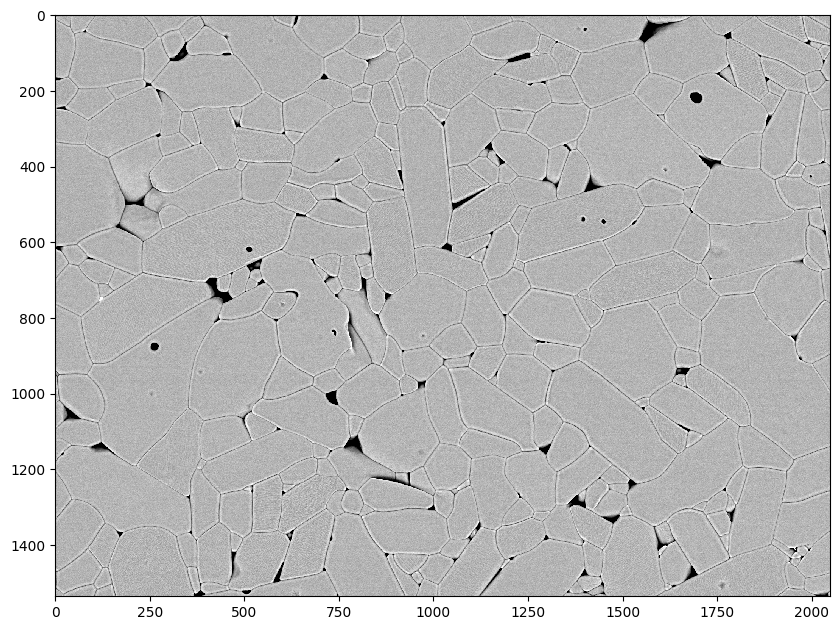

In [2]:
tnia_images_path = Path("D:/images/tnia-python-images")
tnia_images_path = Path("/home/bnorthan/images/tnia-python-images")
parent_path = tnia_images_path / "imagesc/2024_12_19_sem_grain_size_revisit"
labels_path = parent_path / 'training_data'
models_path = parent_path / 'models'

im_name = '211122_AM_Al2O3_SE_021.ome.tiff'
labels_name = '211122_AM_Al2O3_SE_021_sp_labels.tif'
im = imread(str(parent_path / (im_name)))
labels = imread(labels_path / labels_name)
plt.figure(figsize=(10, 8))
plt.imshow(im, cmap='gray')

(dtype('uint8'), 0, 3, (1536, 2048))

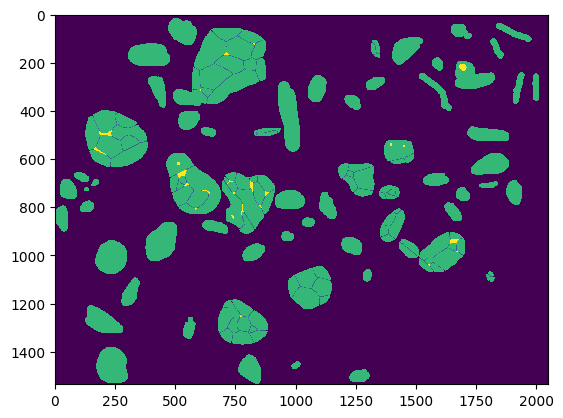

In [3]:
plt.imshow(labels)
labels.dtype, labels.min(), labels.max(), labels.shape

##  View image and label in Napari 

In [4]:
viewer = napari.Viewer()
viewer.add_image(im)
viewer.add_labels(labels)

<Labels layer 'labels' at 0x721d941ccbf0>

## Create Dataset

Create an dataset to represent SEM data.  Since we have only one larger 2D label we will setup the Dataset to generate a random crop with augmentation. 

In [5]:
import albumentations as A

class SEMDataset(Dataset):
    def __init__(self,
                 X,
                 y,
                 split='train',
                 crop_size=64
                ):
        self.X  = X
        self.y = y
        self.split = split
        self.crop_size = crop_size   
        # use the root dir, split and mask logic to point to the correct files
        #self.mask_files = ... # load mask files into sorted list
        #self.raw_files = ... # load raw files into sorted list

        self.transform = A.Compose([
              A.RandomCrop(width=self.crop_size, height=self.crop_size),
              A.HorizontalFlip(p=0.5),
              A.VerticalFlip(p=0.5)
            ])

    def __len__(self):
        return self.X.shape[0]
    
    def augment_data(self, raw, mask):
        
        transformed = self.transform(image=raw, mask=mask)

        raw, mask = transformed['image'], transformed['mask']
       
        return raw, mask
       
    def __getitem__(self, idx):
        """
        In this example there is only one label, but get item will simulate 
        multiple labels by returning a random crop of the image and mask
        """
        
        raw_ = self.X[0,:, :] # load raw to numpy array
        mask_ = self.y[0, :, :] # load mask to numpy array
        
        mask_max = 0

        # keep trying until we get a mask with all 3 classes
        while mask_max != 2:
            raw, mask = self.augment_data(raw_, mask_)
            mask_max = np.max(mask)

        # add channel dim for network
        raw = np.expand_dims(raw, axis=0)
        raw = raw.astype(np.float32)
        mask = np.expand_dims(mask, axis=0)

        return raw, mask

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.0 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


## Set up datasets

In this case since we have only one label the training, testing and validation Datasets aren't really needed... but they would be in a situation with more labels. 

In [6]:
# normalize the image and add channel dim
im_ = quantile_normalization(im)
im_ = np.expand_dims(im_, axis=0)

# add channel dim to labels, convert to int16 and subtract 1 (to make 0 background and -1 unlabeled)
labels_ = np.expand_dims(labels, axis=0)
labels_ = labels_.astype(np.int16)
labels_ = labels_-1

# set crop size
crop_size = 256

# create train, val and test datasets
train_dataset = SEMDataset(im_, labels_, crop_size=crop_size)
val_dataset = SEMDataset(im_, labels_, split='val', crop_size=crop_size)
test_dataset = SEMDataset(im_, labels_, split='test', crop_size=crop_size)    

## Visualize some image/label pairs

Keep in mind these are randomly generated from the single label...  Each time you run the cell you should see slightly different sets of crops with Image and label corresponding.  Note:  Since the labels are sparse the image is usually not 100% labeled. 

-1 2 0.0 1.0
-1 2 0.0 1.0
-1 2 0.0 1.0


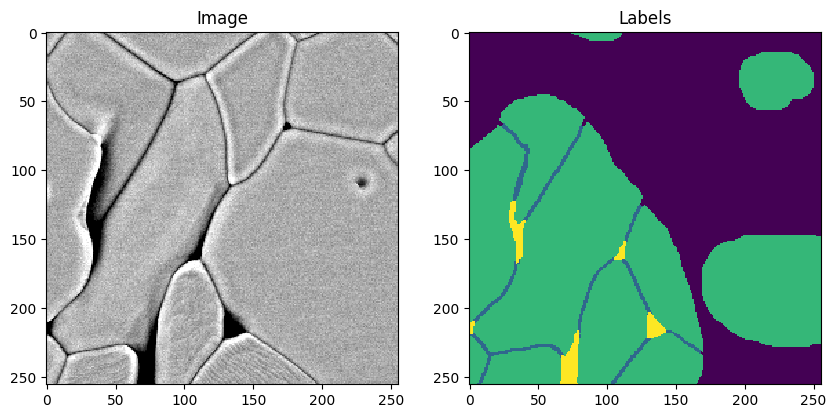

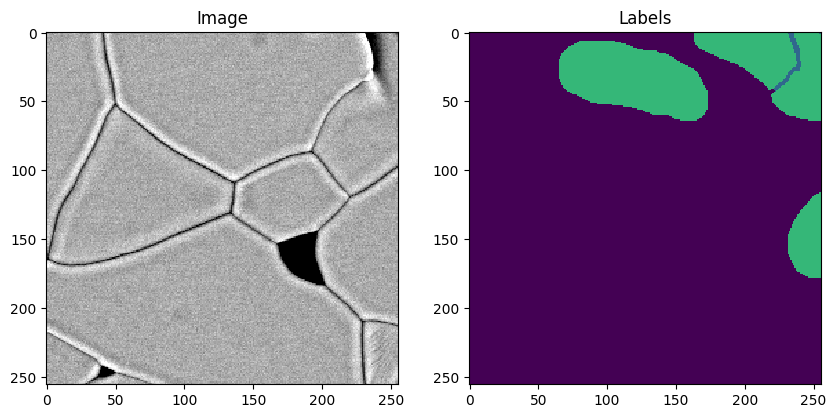

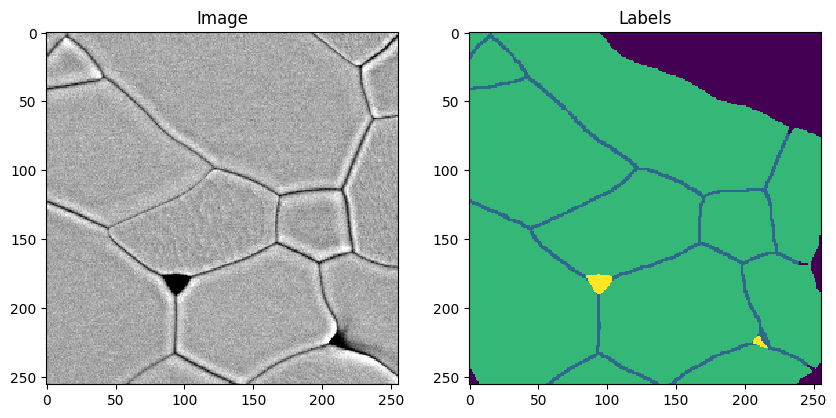

In [7]:
# visualize random batch

raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([raw[0], mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', 'viridis'])
print(mask.min(), mask.max(), raw.min(), raw.max())
raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([raw[0], mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', 'viridis'])
print(mask.min(), mask.max(), raw.min(), raw.max())
 
raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([raw[0], mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', 'viridis'])
print(mask.min(), mask.max(), raw.min(), raw.max())

## Setup training loop

Here we set up the training loop.  Note we have a 'steps_per_update' parameter... at least on my laptop I did not have enough memory to setup a batch size large enough for stable updates... thus am accumulating gradient for n steps, then back propagating. 

So each 'epoch' in this case is 100 steps, with gradients accumulating, then an back-prop.

In [34]:
steps_per_update = 100   


def train(train_loader, val_loader, net, loss_fn, optimizer, dtype, num_epochs):

    # set train flags, initialize step
    net.train() 
    loss_fn.train()
    epoch = 0

    while epoch < num_epochs:
        # reset data loader to get random augmentations
        np.random.seed()
        
        # reset pbar
        #pbar.reset()
        #pbar = tqdm(total=steps_per_update)
        #pbar.set_description(f"Epoch {step}")
    
        # zero gradients
        optimizer.zero_grad()

        total_loss = 0.0  # To track the sum of losses for averaging
        
        with tqdm(total=steps_per_update, desc=f"Epoch {epoch}", leave=True) as pbar:
    
            for i in range(steps_per_update):
            
                tmp_loader = iter(train_loader)
                
                for feature, label in tmp_loader:
                    label = label.type(dtype)
                    label = label.to(device)
                    feature = feature.to(device)
                    
                    # forward
                    predicted = net(feature)
                    label=torch.squeeze(label,1)
                    loss_value = loss_fn(input=predicted, target=label)

                    # Accumulate loss for averaging
                    total_loss += loss_value.item()

                    # pass through loss
                    loss_value.backward()
                    
                    pbar.update(1)
                
                    optimizer.step()

        # Compute the average loss over all steps
        average_loss = total_loss / steps_per_update
            
        writer.add_scalar('loss',average_loss,epoch)
        epoch += 1
        if True: #step % 100 == 0:
            net.eval()
            tmp_val_loader = iter(val_loader)
            acc_loss = []
            for feature, label in tmp_val_loader:                    
                label = label.type(dtype)
                label = label.to(device)
                feature = feature.to(device)
                
                predicted = net(feature)
                label=torch.squeeze(label,1)
                loss_value = loss_fn(input=predicted, target=label)
                #loss_value, _ = model_step(net, loss_fn, optimizer, feature, label, train_step=False)
                
                acc_loss.append(loss_value.cpu().detach().numpy())
            writer.add_scalar('val_loss',np.mean(acc_loss),epoch)
            net.train()

            #print(f'training loss at epoch {step} is {average_loss}')
            pbar.write(f'training loss at epoch {epoch} is {average_loss}')
            #print(np.mean(acc_loss))

## Setup loss function and net

We use cross-entropy-loss and need to set the ignore index and the weights (which are crude estimates right now).

We also set ```act=None``` in the ```BasicUNet```.  This is because the documentation indicates cross-entropy-loss applies a soft max as part of the calculation.  (Thus when predicting need to remember to apply a soft max).

In [35]:
class_counts = torch.tensor([1,98,1], dtype=torch.float32)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1, weight=class_weights)

dtype = torch.LongTensor

in_channels=1
padding='same'
out_channels = 3

net = BasicUNet(
                spatial_dims=2,
                in_channels=in_channels,
                out_channels=out_channels,
                #features=[16, 16, 32, 64, 128, 16],
                act=None,
                #norm="batch",
                dropout=0.25,
            )

# or alternatively load a model if continuing training
#net = torch.load( Path(models_path) / 'model5')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = net.to(device)
loss_fn = loss_fn.to(device)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)

BasicUNet features: (32, 32, 64, 128, 256, 32).


## Set optimizer and perform training

In [38]:
train_batch_size = 8 
test_batch_size = 8

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# make dataloaders
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size)

num_epochs = 100

train(train_loader, val_loader, net, loss_fn, optimizer, dtype, num_epochs)

Epoch 0: 100%|██████████| 100/100 [00:03<00:00, 32.99it/s]


training loss at epoch 1 is 0.15879277111031115


Epoch 1: 100%|██████████| 100/100 [00:03<00:00, 27.96it/s]


training loss at epoch 2 is 0.1409695998392999


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 39.59it/s]


training loss at epoch 3 is 0.12241201657801866


Epoch 3: 100%|██████████| 100/100 [00:04<00:00, 21.67it/s]


training loss at epoch 4 is 0.15076417896896602


Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 55.97it/s]


training loss at epoch 5 is 0.15208671921864153


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 41.87it/s]


training loss at epoch 6 is 0.14796002953313292


Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 77.73it/s]


training loss at epoch 7 is 0.12845214284956455


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 29.15it/s]


training loss at epoch 8 is 0.12572827716358007


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 44.39it/s]


training loss at epoch 9 is 0.1211157454084605


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 41.76it/s]


training loss at epoch 10 is 0.13213057699613273


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


training loss at epoch 11 is 0.10581570470705629


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 40.72it/s]


training loss at epoch 12 is 0.12945757097564636


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 42.77it/s]


training loss at epoch 13 is 0.12996346497908234


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.94it/s]


training loss at epoch 14 is 0.11450474648736417


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


training loss at epoch 15 is 0.12780585552565754


Epoch 15: 100%|██████████| 100/100 [00:01<00:00, 50.42it/s]


training loss at epoch 16 is 0.16947956402786077


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 39.85it/s]


training loss at epoch 17 is 0.11498878762125969


Epoch 17: 100%|██████████| 100/100 [00:01<00:00, 67.95it/s]


training loss at epoch 18 is 0.10716917010955512


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 30.86it/s]


training loss at epoch 19 is 0.10967289634980261


Epoch 19: 100%|██████████| 100/100 [00:01<00:00, 58.27it/s]


training loss at epoch 20 is 0.12288884611800313


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 30.45it/s]


training loss at epoch 21 is 0.12847986099310219


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 35.19it/s]


training loss at epoch 22 is 0.12964536934159696


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


training loss at epoch 23 is 0.12791299975477158


Epoch 23: 100%|██████████| 100/100 [00:01<00:00, 53.01it/s]


training loss at epoch 24 is 0.11803918853402137


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.11it/s]


training loss at epoch 25 is 0.13155131839215756


Epoch 25: 100%|██████████| 100/100 [00:01<00:00, 77.24it/s]


training loss at epoch 26 is 0.12009600015357137


Epoch 26: 100%|██████████| 100/100 [00:01<00:00, 74.56it/s]


training loss at epoch 27 is 0.12336055838502943


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 33.38it/s]


training loss at epoch 28 is 0.12229455813765526


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 25.40it/s]


training loss at epoch 29 is 0.12768220125697552


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 33.08it/s]


training loss at epoch 30 is 0.10682547099888325


Epoch 30: 100%|██████████| 100/100 [00:01<00:00, 81.37it/s]


training loss at epoch 31 is 0.13610207499936222


Epoch 31: 100%|██████████| 100/100 [00:02<00:00, 49.00it/s]


training loss at epoch 32 is 0.12599077108316123


Epoch 32: 100%|██████████| 100/100 [00:02<00:00, 45.87it/s]


training loss at epoch 33 is 0.12081178384833038


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 26.45it/s]


training loss at epoch 34 is 0.12070857180282474


Epoch 34: 100%|██████████| 100/100 [00:01<00:00, 67.42it/s]


training loss at epoch 35 is 0.10131841529160739


Epoch 35: 100%|██████████| 100/100 [00:02<00:00, 39.54it/s]


training loss at epoch 36 is 0.09761693650856614


Epoch 36: 100%|██████████| 100/100 [00:02<00:00, 38.85it/s]


training loss at epoch 37 is 0.1215820395667106


Epoch 37: 100%|██████████| 100/100 [00:01<00:00, 61.34it/s]


training loss at epoch 38 is 0.11647655569948256


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


training loss at epoch 39 is 0.10608884969726205


Epoch 39: 100%|██████████| 100/100 [00:01<00:00, 79.79it/s]


training loss at epoch 40 is 0.11361262679100037


Epoch 40: 100%|██████████| 100/100 [00:02<00:00, 43.25it/s]


training loss at epoch 41 is 0.15768621529452503


Epoch 41: 100%|██████████| 100/100 [00:02<00:00, 48.76it/s]


training loss at epoch 42 is 0.11075857970863581


Epoch 42: 100%|██████████| 100/100 [00:02<00:00, 35.37it/s]


training loss at epoch 43 is 0.12419685201719403


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 33.10it/s]


training loss at epoch 44 is 0.12254608846269548


Epoch 44: 100%|██████████| 100/100 [00:02<00:00, 38.42it/s]


training loss at epoch 45 is 0.11808732931502164


Epoch 45: 100%|██████████| 100/100 [00:02<00:00, 35.94it/s]


training loss at epoch 46 is 0.11419487493112683


Epoch 46: 100%|██████████| 100/100 [00:02<00:00, 35.65it/s]


training loss at epoch 47 is 0.13654354530386625


Epoch 47: 100%|██████████| 100/100 [00:02<00:00, 42.92it/s]


training loss at epoch 48 is 0.13060324521735311


Epoch 48: 100%|██████████| 100/100 [00:02<00:00, 40.68it/s]


training loss at epoch 49 is 0.1399437003210187


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 43.43it/s]


training loss at epoch 50 is 0.11479791436344385


Epoch 50: 100%|██████████| 100/100 [00:01<00:00, 60.30it/s]


training loss at epoch 51 is 0.13167188690043985


Epoch 51: 100%|██████████| 100/100 [00:02<00:00, 34.83it/s]


training loss at epoch 52 is 0.14291072240099312


Epoch 52: 100%|██████████| 100/100 [00:02<00:00, 49.98it/s]


training loss at epoch 53 is 0.10813818139024078


Epoch 53: 100%|██████████| 100/100 [00:01<00:00, 71.61it/s]


training loss at epoch 54 is 0.10683501502498985


Epoch 54: 100%|██████████| 100/100 [00:02<00:00, 39.33it/s]


training loss at epoch 55 is 0.11900161166675388


Epoch 55: 100%|██████████| 100/100 [00:01<00:00, 56.82it/s]


training loss at epoch 56 is 0.12304804551415145


Epoch 56: 100%|██████████| 100/100 [00:01<00:00, 62.48it/s]


training loss at epoch 57 is 0.14044892043806612


Epoch 57: 100%|██████████| 100/100 [00:02<00:00, 43.97it/s]


training loss at epoch 58 is 0.13134840941987933


Epoch 58: 100%|██████████| 100/100 [00:02<00:00, 33.41it/s]


training loss at epoch 59 is 0.12827393324114383


Epoch 59: 100%|██████████| 100/100 [00:01<00:00, 50.81it/s]


training loss at epoch 60 is 0.15258485279046


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 32.82it/s]


training loss at epoch 61 is 0.11792601230554282


Epoch 61: 100%|██████████| 100/100 [00:01<00:00, 61.93it/s]


training loss at epoch 62 is 0.10648788148537278


Epoch 62: 100%|██████████| 100/100 [00:01<00:00, 84.17it/s]


training loss at epoch 63 is 0.14080628572031856


Epoch 63: 100%|██████████| 100/100 [00:02<00:00, 47.37it/s]


training loss at epoch 64 is 0.11837000219151378


Epoch 64: 100%|██████████| 100/100 [00:01<00:00, 50.71it/s]


training loss at epoch 65 is 0.1403337481059134


Epoch 65: 100%|██████████| 100/100 [00:02<00:00, 42.13it/s]


training loss at epoch 66 is 0.10831889735534787


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


training loss at epoch 67 is 0.09520647478289902


Epoch 67: 100%|██████████| 100/100 [00:01<00:00, 84.37it/s]


training loss at epoch 68 is 0.10305359059013426


Epoch 68: 100%|██████████| 100/100 [00:01<00:00, 88.95it/s]


training loss at epoch 69 is 0.1187118106521666


Epoch 69: 100%|██████████| 100/100 [00:01<00:00, 94.34it/s] 


training loss at epoch 70 is 0.11662054245360196


Epoch 70: 100%|██████████| 100/100 [00:01<00:00, 95.29it/s]


training loss at epoch 71 is 0.1404778046021238


Epoch 71: 100%|██████████| 100/100 [00:00<00:00, 100.26it/s]


training loss at epoch 72 is 0.1462439725548029


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 31.21it/s]


training loss at epoch 73 is 0.1126007641851902


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 25.47it/s]


training loss at epoch 74 is 0.11517566457390785


Epoch 74: 100%|██████████| 100/100 [00:01<00:00, 58.06it/s]


training loss at epoch 75 is 0.13500080032274128


Epoch 75: 100%|██████████| 100/100 [00:01<00:00, 74.90it/s]


training loss at epoch 76 is 0.1138105295971036


Epoch 76: 100%|██████████| 100/100 [00:01<00:00, 59.46it/s]


training loss at epoch 77 is 0.13106336181052028


Epoch 77: 100%|██████████| 100/100 [00:02<00:00, 38.18it/s]


training loss at epoch 78 is 0.14084939538501204


Epoch 78: 100%|██████████| 100/100 [00:02<00:00, 34.88it/s]


training loss at epoch 79 is 0.1107299296092242


Epoch 79: 100%|██████████| 100/100 [00:01<00:00, 51.78it/s]


training loss at epoch 80 is 0.13535911208949983


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 29.53it/s]


training loss at epoch 81 is 0.11882166202180088


Epoch 81: 100%|██████████| 100/100 [00:02<00:00, 35.55it/s]


training loss at epoch 82 is 0.12132825567387044


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


training loss at epoch 83 is 0.12402152203023434


Epoch 83: 100%|██████████| 100/100 [00:02<00:00, 38.99it/s]


training loss at epoch 84 is 0.11018254184164107


Epoch 84: 100%|██████████| 100/100 [00:02<00:00, 44.87it/s]


training loss at epoch 85 is 0.10946581568568944


Epoch 85: 100%|██████████| 100/100 [00:02<00:00, 39.28it/s]


training loss at epoch 86 is 0.10057883178815245


Epoch 86: 100%|██████████| 100/100 [00:02<00:00, 45.02it/s]


training loss at epoch 87 is 0.09638426720164717


Epoch 87: 100%|██████████| 100/100 [00:02<00:00, 45.37it/s]


training loss at epoch 88 is 0.09555147988721728


Epoch 88: 100%|██████████| 100/100 [00:02<00:00, 44.24it/s]


training loss at epoch 89 is 0.11687072738073766


Epoch 89: 100%|██████████| 100/100 [00:01<00:00, 65.52it/s]


training loss at epoch 90 is 0.10313536809757352


Epoch 90: 100%|██████████| 100/100 [00:02<00:00, 45.45it/s]


training loss at epoch 91 is 0.09508718773722649


Epoch 91: 100%|██████████| 100/100 [00:04<00:00, 21.37it/s]


training loss at epoch 92 is 0.0990142058301717


Epoch 92: 100%|██████████| 100/100 [00:02<00:00, 44.58it/s]


training loss at epoch 93 is 0.09023423510603606


Epoch 93: 100%|██████████| 100/100 [00:02<00:00, 38.65it/s]


training loss at epoch 94 is 0.11096449638716877


Epoch 94: 100%|██████████| 100/100 [00:02<00:00, 42.15it/s]


training loss at epoch 95 is 0.13101786527782677


Epoch 95: 100%|██████████| 100/100 [00:02<00:00, 38.16it/s]


training loss at epoch 96 is 0.13163667515851557


Epoch 96: 100%|██████████| 100/100 [00:02<00:00, 41.68it/s]


training loss at epoch 97 is 0.12224799623712897


Epoch 97: 100%|██████████| 100/100 [00:02<00:00, 33.48it/s]


training loss at epoch 98 is 0.12430026163347066


Epoch 98: 100%|██████████| 100/100 [00:02<00:00, 34.80it/s]


training loss at epoch 99 is 0.1369592321384698


Epoch 99: 100%|██████████| 100/100 [00:02<00:00, 33.66it/s]

training loss at epoch 100 is 0.14313708351925014


In [39]:
torch.save(net, Path(models_path) / 'model11')